<a href="https://colab.research.google.com/github/yhtang/SINN/blob/main/OU_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Wed Nov 15 16:22:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:98:00.0 Off |                    0 |
| N/A   27C    P0    66W / 300W |   1971MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)

In [3]:
device = torch.device('cuda')

In [4]:
torch.cuda.is_available()

True

200.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1500, 400)
(400, 400) (400, 400)
CPU times: user 493 ms, sys: 4.34 ms, total: 497 ms
Wall time: 500 ms


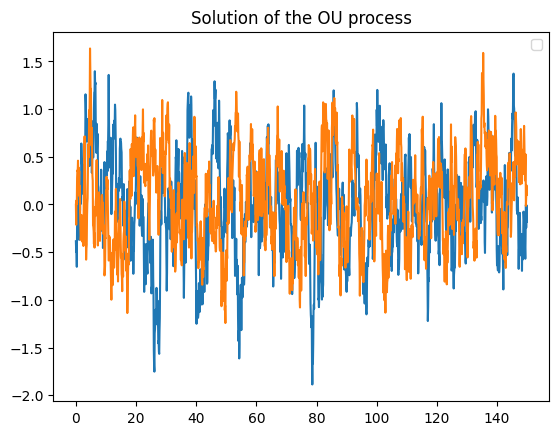

In [5]:
%%time
#### Generating SINN training data by solving SDE

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad


#### Parameters 
sigma = 0.5
gamma = 1                            # coupling constant 
beta = 1                             # Inverse temperature, i.e. T=1/beta
dt = 0.01                            # Step-size of the SDE solver 
delta_t = 0.1                        # Step-size of the temporally coarse-grained path
batch = 400                          # Batch size 
sec_length = 400                     # Length of the input sequence 


#### SDE solver (EM scheme) 
Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length)          
gap=int(delta_t/dt)
t_store=t[0:-1:gap]
q_store = np.zeros([t_store.size+1,batch])
q=np.zeros((2,batch))
# solve SDE
j=1
for i in range(1,length):
    q[1,:] = q[0,:] -gamma*q[0,:]*dt+ np.random.randn(1,batch)*np.sqrt(2*dt*sigma**2)
    if i % gap ==0:            
        q_store[j,:]=q[1,:]
        j=j+1
    q[0,:]=q[1,:]
Toss=int(t_store.size/4)        
q_store=q_store[Toss:-1,:]         
print(q_store.shape)


plt.figure(1)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,i])
plt.legend()
plt.title("Solution of the OU process")



#### Constructing the sample traj for SINN learning 
ini=np.random.randn(sec_length,batch)
Traj=q_store[0:sec_length,:]
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
pdf_exact=np.exp(-x**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)
print(ini.shape, Traj.shape)

In [6]:
torch.__version__

'2.0.1+cu118'

In [7]:
print(torch.version.cuda)

11.8


In [8]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 1), device=device)

Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch,1)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 1]) torch.float32


In [9]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_q2 = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)
loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)

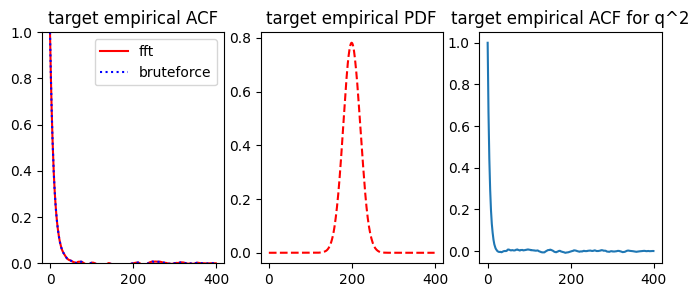

In [10]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(1, 3, figsize=(8, 3))
axs[0].plot(loss_acf_fft._target.cpu(),'r', label='fft')
axs[0].plot(loss_acf_bruteforce._target.cpu(),'b:', label='bruteforce')
axs[0].set_title('target empirical ACF')
axs[0].set_ylim([0,1])
x_grid=-np.linspace(-5,5,num=sec_length)
axs[1].plot(loss_pdf_empirical._target.cpu(),'r--')
axs[1].set_title('target empirical PDF')
axs[2].plot(loss_acf_q2._target.cpu())
axs[2].set_title('target empirical ACF for q^2')
axs[0].legend()
plt.show()

In [11]:
### Defining SINN model 
net = SINN(1, 2, 1, 1,'LSTM').to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [12]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(10000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_empirical(prediction)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.4f, %.4f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
#     if loss<=0.0005 and loss_val<=0.0005:
#             break
print('Training finished')

[0]-th step loss: 0.2735, 0.2731
[50]-th step loss: 0.2456, 0.2451
[100]-th step loss: 0.2015, 0.2006
[150]-th step loss: 0.1490, 0.1483
[200]-th step loss: 0.1088, 0.1085
[250]-th step loss: 0.0807, 0.0805
[300]-th step loss: 0.0606, 0.0603
[350]-th step loss: 0.0463, 0.0460
[400]-th step loss: 0.0370, 0.0369
[450]-th step loss: 0.0310, 0.0309
[500]-th step loss: 0.0262, 0.0262
[550]-th step loss: 0.0222, 0.0222
[600]-th step loss: 0.0189, 0.0187
[650]-th step loss: 0.0159, 0.0158
[700]-th step loss: 0.0136, 0.0134
[750]-th step loss: 0.0114, 0.0114
[800]-th step loss: 0.0098, 0.0097
[850]-th step loss: 0.0084, 0.0083
[900]-th step loss: 0.0071, 0.0071
[950]-th step loss: 0.0061, 0.0061
[1000]-th step loss: 0.0052, 0.0052
[1050]-th step loss: 0.0045, 0.0044
[1100]-th step loss: 0.0036, 0.0037
[1150]-th step loss: 0.0031, 0.0030
[1200]-th step loss: 0.0025, 0.0025
[1250]-th step loss: 0.0021, 0.0020
[1300]-th step loss: 0.0018, 0.0017
[1350]-th step loss: 0.0015, 0.0015
[1400]-th step 

In [13]:
%%time
# Training SINN
for step in range(10000, 20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_pdf_empirical(prediction)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_bruteforce(pred_val)+ loss_pdf_empirical(pred_val)
            loss_val_acf = loss_acf_bruteforce(pred_val)
            print('[%d]-th step loss: %.4f, %.4f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
#     if loss<=0.0005 and loss_val<=0.0005:
#             break
print('Training finished')

[10000]-th step loss: 0.0001, 0.0001
[10050]-th step loss: 0.0001, 0.0001
[10100]-th step loss: 0.0001, 0.0001
[10150]-th step loss: 0.0001, 0.0001
[10200]-th step loss: 0.0001, 0.0001
[10250]-th step loss: 0.0001, 0.0001
[10300]-th step loss: 0.0001, 0.0001
[10350]-th step loss: 0.0001, 0.0001
[10400]-th step loss: 0.0001, 0.0001
[10450]-th step loss: 0.0000, 0.0001
[10500]-th step loss: 0.0001, 0.0001
[10550]-th step loss: 0.0001, 0.0001
[10600]-th step loss: 0.0001, 0.0001
[10650]-th step loss: 0.0001, 0.0001
[10700]-th step loss: 0.0000, 0.0001
[10750]-th step loss: 0.0000, 0.0001
[10800]-th step loss: 0.0001, 0.0001
[10850]-th step loss: 0.0001, 0.0001
[10900]-th step loss: 0.0001, 0.0001
[10950]-th step loss: 0.0001, 0.0001
[11000]-th step loss: 0.0001, 0.0001
[11050]-th step loss: 0.0001, 0.0001
[11100]-th step loss: 0.0001, 0.0001
[11150]-th step loss: 0.0001, 0.0001
[11200]-th step loss: 0.0001, 0.0001
[11250]-th step loss: 0.0001, 0.0001
[11300]-th step loss: 0.0001, 0.0001
[

In [14]:
from prettytable import PrettyTable

In [15]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [16]:
count_parameters(net)

+---------------------------+------------+
|          Modules          | Parameters |
+---------------------------+------------+
| architecture.weight_ih_l0 |     8      |
| architecture.weight_hh_l0 |     16     |
|  architecture.bias_ih_l0  |     8      |
|  architecture.bias_hh_l0  |     8      |
|       readout.weight      |     2      |
|        readout.bias       |     1      |
+---------------------------+------------+
Total Trainable Params: 43


43

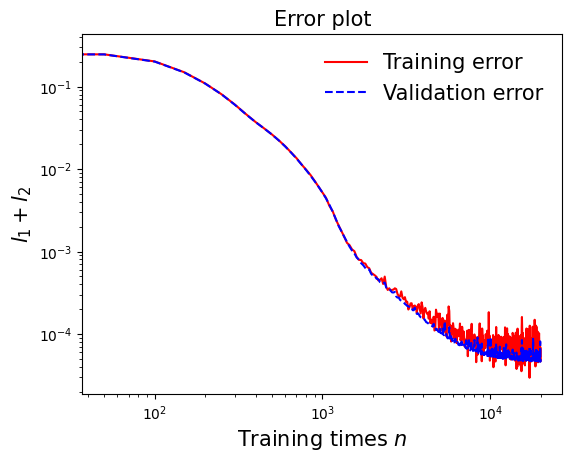

In [17]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_training_error.pdf", dpi=150)

In [18]:
# # Constructing Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

([<matplotlib.axis.YTick at 0x1529d1e058b0>,
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

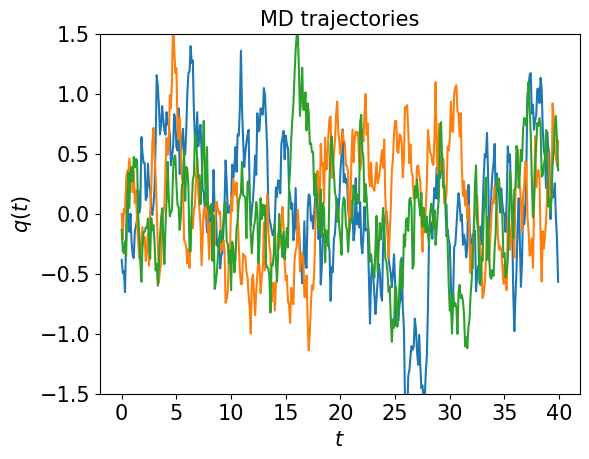

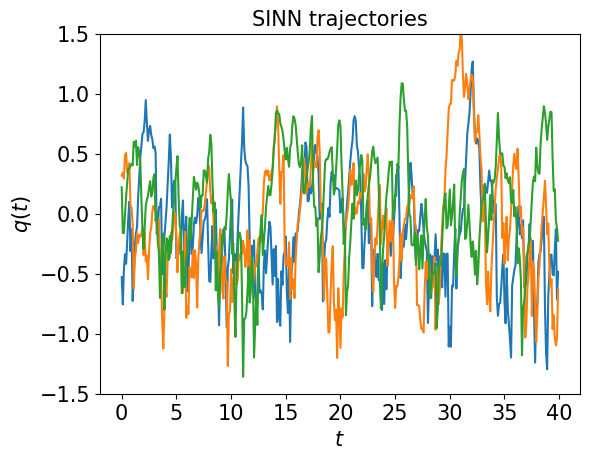

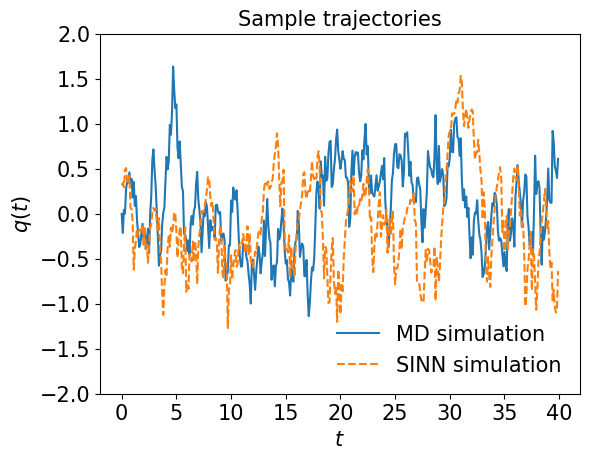

In [19]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
plt.plot(T[skip:]-T[skip], Traj[skip:, 2])   
plt.ylim([-1.5,1.5])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     
# plt.savefig("figs/OU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.ylim([-1.5,1.5])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_traj_multi.pdf", dpi=150)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 1], label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 1],'--',label='SINN simulation')
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)
# plt.savefig("figs/OU_traj.pdf", dpi=150)

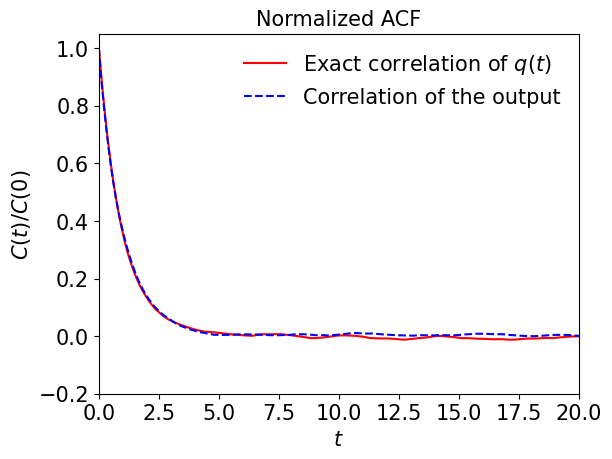

In [20]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF 


acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t,'r',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,20)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf.pdf", dpi=150)

(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ]),
 [Text(0, 0.0, '0.00'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.5, '0.50'),
  Text(0, 0.75, '0.75'),
  Text(0, 1.0, '1.00'),
  Text(0, 1.25, '1.25'),
  Text(0, 1.5, '1.50'),
  Text(0, 1.75, '1.75'),
  Text(0, 2.0, '2.00')])

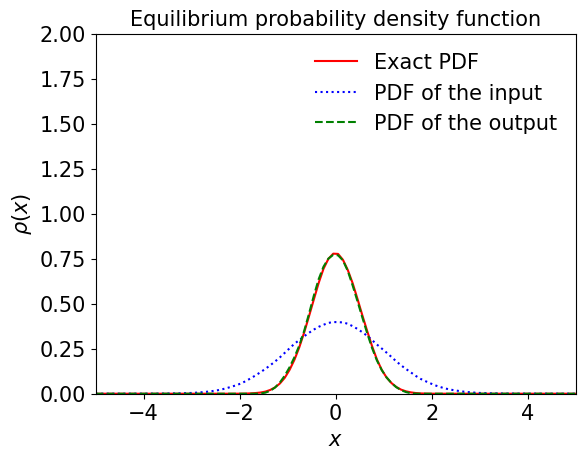

In [21]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF 

rho_data =  StatLoss.gauss_kde(target, -5, 5, 100, bw=None).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100, bw=None).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100, bw=None).cpu()

x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy(), 'r',label=r'Exact PDF')    # target PDF
plt.plot(x, rho_input.numpy(), 'b:', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label=r'PDF of the output')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,2)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_pdf.pdf", dpi=150)

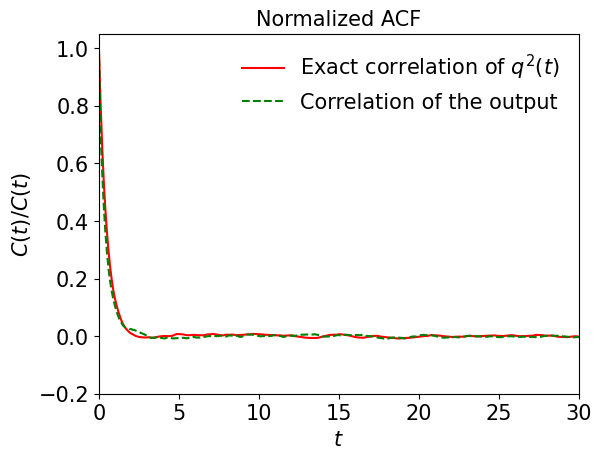

In [22]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf2.pdf", dpi=150)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500')])

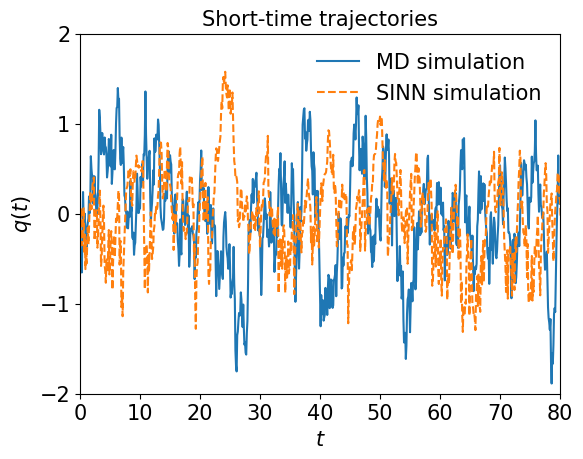

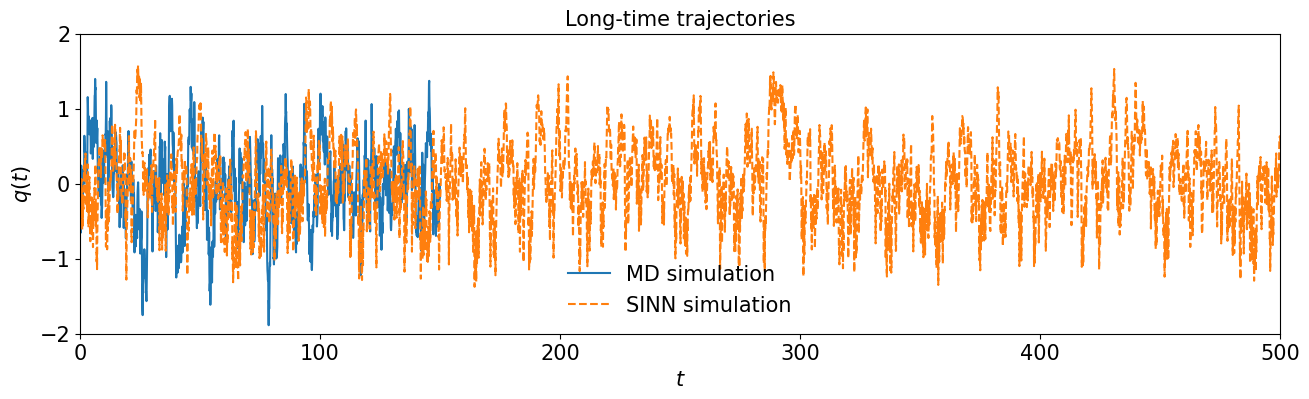

In [23]:
# Test 5: plot the expolation result, i.e. Prediction of the OU dynamics for longer time 

[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new)
acf_p=StatLoss.acf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1],'--',label='SINN simulation')
plt.xlim([0,80])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/OU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1],'--',label='SINN simulation')
plt.xlim([0,500])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/OU_traj_lT.pdf", dpi=150)

# END